# Burger Delivery Market in Melbourne

Analysis using data collected on DoorDash using scrpaing technique.

In [1]:
import glob
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import re
import json

import nltk
from collections import Counter
from wordcloud import WordCloud
import random
import seaborn as sns

#nltk.download('stopwords')

### Data

In [2]:
DATA_PATH = "/Users/leo/Development/food/data"

WEST_LIMIT = 144.58636245678318
EAST_LIMIT = 145.52543159101887
NORT_LIMIT = -37.50749853264523
SOUTH_LIMIT = -38.453343876113394

In [3]:
# listing data
all_files = glob.glob(os.path.join(DATA_PATH , "MEL/listing/*/*.csv"), recursive=False)
df_stores = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_stores = df_stores.drop_duplicates("store_id")

mask = (SOUTH_LIMIT < df_stores.lat) & (df_stores.lat < NORT_LIMIT) & (WEST_LIMIT < df_stores.lng) & (df_stores.lng < EAST_LIMIT)
df_stores = df_stores[mask]

In [4]:
# add suburbs
GEO_PATH = "/Users/leo/Development/food/geo"
victoria = geopandas.read_file(os.path.join(GEO_PATH , "victoria_suburbs.geojson.json"))
victoria = victoria[["loc_pid", "vic_loca_2", "geometry"]]
victoria = victoria.rename(columns={"vic_loca_2": "suburb", "loc_pid": "suburb_id"})
victoria["suburb"] = victoria.suburb.str.title()


# add subburb to store dataset
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_stores.lng, df_stores.lat)]
gdf = GeoDataFrame(df_stores, crs="EPSG:4283", geometry=geometry)
gdf = gdf.sjoin(victoria, how="inner", predicate='intersects')
df_stores = pd.DataFrame(gdf.drop(columns='geometry'))
del geometry

# select suburb with at least 10 stores
store_suburbs = (gdf
 .groupby("suburb_id")
 .agg({"suburb": "first", "store_id": "count"})
 .query("store_id >= 10")
).index.values
del gdf
victoria = victoria[victoria.suburb_id.isin(store_suburbs)]

In [5]:
# process categories
df_stores["price_category"] = df_stores.categories.apply(lambda s: s.count("$"))
df_stores["tags"] = df_stores.categories.apply(lambda s: re.split("\s*,\s*", s.replace("$", "").replace(" • ", "")))

In [6]:
# Remove Convenience Stores
mask = df_stores.tags.apply(lambda l: "Grocery" not in l) & df_stores.tags.apply(lambda l: "Convenience" not in l)
df_stores = df_stores[mask].copy()

In [7]:
n_restaurantes = df_stores.shape[0]
avg_rest_demand = (df_stores.n_reviews.sum() / df_stores.shape[0])

In [8]:
mask = df_stores.tags.apply(lambda l: "Burgers" in l)
df_stores = df_stores[mask].copy()

# data cleaning
# remove Subway
mask = df_stores.business_id != 327788
df_stores = df_stores[mask].copy()
# remove Kebab Hut
mask = df_stores.business_id != 332295
df_stores = df_stores[mask].copy()

In [9]:
n_burgers = df_stores.shape[0]
avg_burger_demand = (df_stores.n_reviews.sum() / df_stores.shape[0])

## Summary

In [10]:
print("Burgers Stores: %s - Represent %d %% of total stores" % (n_burgers, n_burgers/n_restaurantes * 100))

Burgers Stores: 548 - Represent 10 % of total stores


In [110]:
demand_lift = 100 * (avg_burger_demand/avg_rest_demand  - 1)
print("Orders in burgers stores are %d %% higher that any other restaurante" % demand_lift)

Orders in burgers stores are 77 % higher that any other restaurante


## Market Share

In [12]:
df_business = (df_stores
 .groupby("business_id", as_index=False)
 .agg({"name": "first",
       "store_id": "count",
       "n_reviews": "sum",
       "rating": "mean",
       "tags": "first",
       "price_category": "mean"
      })
 .sort_values("n_reviews", ascending=False)
)

df_business = df_business.rename(columns={"store_id": "n_stores"})
df_business["business_id"] = df_business.business_id.astype(int)
df_business["price_category"] = df_business.price_category.round().astype(int)

df_business["stores_demand_index"] = (df_business.n_reviews / df_business.n_stores) / avg_rest_demand

df_business["market_share_index"] = 100 * (df_business.n_reviews / df_business.n_reviews.sum())
df_business["market_share_cumsum"] = df_business.market_share_index.cumsum()

In [13]:
print("%s burger brands - %s brands represent 70%% of market share" %\
      (df_business.shape[0], (df_business.market_share_cumsum < 70.5).sum()))

403 burger brands - 7 brands represent 70% of market share


In [14]:
df_business.head(10)

,business_id,name,n_stores,n_reviews,rating,tags,price_category,stores_demand_index,market_share_index,market_share_cumsum
69,393499,McDonald's,32,73019.0,4.071368,"[American, Burgers]",2,12.850684,42.266884,42.266884
50,341404,Grill'd,19,22487.0,4.514072,"[Burgers, Sandwiches]",2,6.665278,13.016549,55.283433
183,860686,Hungry Jacks,15,12598.0,4.093021,"[Burgers, American]",2,4.729886,7.292324,62.575757
36,321692,Betty's Burgers,6,4482.0,4.336394,"[Burgers, Chicken]",2,4.206888,2.594396,65.170152
166,803460,300 Grams,4,3334.0,4.728404,"[Burgers, Fast Food]",1,4.694031,1.929878,67.100031
4,294084,Easey's,2,2827.0,4.486136,"[Burgers, American]",1,7.960423,1.636403,68.736433
42,328903,Coburger & Co,1,2573.0,4.694520,"[Burgers, American]",1,14.490392,1.489375,70.225809
22,297957,Oporto,6,2421.0,4.359629,"[Portuguese, Burgers]",2,2.272395,1.401390,71.627199
81,426771,Burgertory,6,2173.0,4.451230,"[Burgers, Fries]",1,2.039618,1.257836,72.885035
28,307220,The Royale Brothers,1,1934.0,4.616856,"[Burgers, American]",1,10.891729,1.119492,74.004527


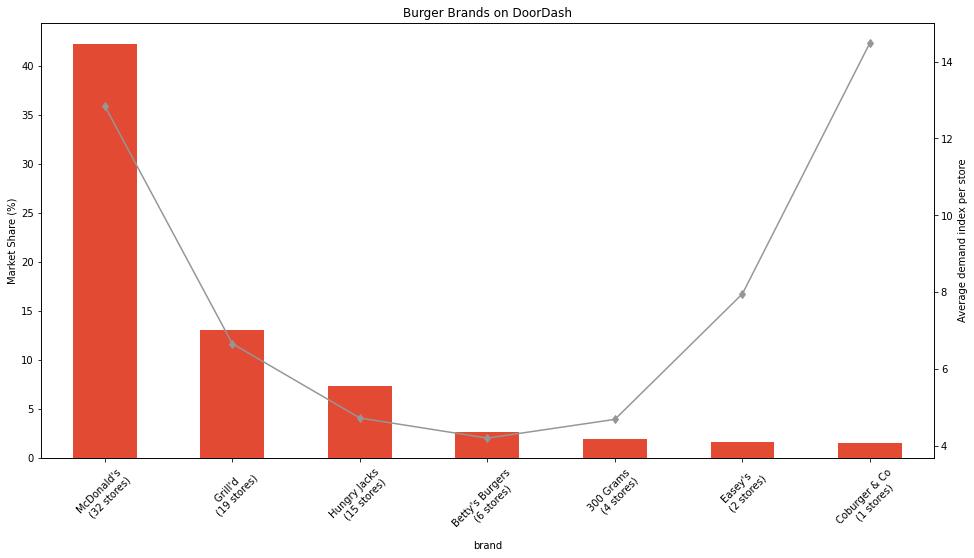

In [15]:
mask = (df_business.market_share_cumsum < 71)

df_plot = df_business[mask].copy()
df_plot["brand"] = df_business[mask].apply(lambda row: f"{row['name']} \n ({row['n_stores']} stores)", axis=1)
df_plot = df_plot.set_index("brand")

ax = (df_plot
 .plot.bar(y='market_share_index', color="#e34a33", label="store_id", rot=45, figsize=(16,8), legend=False)
);
plt.ylabel('Market Share (%)');

(df_plot
 .plot.line(y='stores_demand_index', color="#969696",  marker='d',rot=45, secondary_y=True, ax=ax, legend=False)
);
plt.ylabel('Average demand index per store');


plt.xlabel('Brand');
plt.title("Burger Brands on DoorDash");

## Suburbs

In [46]:
df_suburb_counter = df_stores.groupby("suburb").agg({"store_id": "count", "n_reviews": "sum"})
df_suburb_counter = df_suburb_counter.rename(columns={"store_id": "n_stores"})
df_suburb_counter["perc_stores"] = (df_suburb_counter.n_stores / df_stores.shape[0] * 100).round(1)
df_suburb_counter["perc_reviews"] = (df_suburb_counter.n_reviews / df_stores.n_reviews.sum() * 100).round(1)
df_suburb_counter["store_demand"] = df_suburb_counter.n_reviews / df_suburb_counter.n_stores
df_suburb_counter["stores_demand_index"] = df_suburb_counter.store_demand / avg_rest_demand
df_suburb_counter["stores_demand_perc_lift"] = ((df_suburb_counter.stores_demand_index  - 1) * 100).round(0)

In [115]:
# Evaluation of stores performance in suburbs with greater offer of burgers
(df_suburb_counter
 .query("n_stores >= 10")
 .sort_values("stores_demand_index", ascending=False)
 .head(10)
 [['n_stores', 'perc_stores', 'perc_reviews', 'stores_demand_index']]
 .round(1)
)

,n_stores,perc_stores,perc_reviews,stores_demand_index
suburb,,,,
Preston,15,2.7,6.9,4.5
Richmond,13,2.4,3.6,2.7
Windsor,11,2.0,2.8,2.4
Moonee Ponds,10,1.8,2.3,2.2
Melbourne,51,9.3,10.4,2.0
South Yarra,18,3.3,3.6,2.0
Prahran,13,2.4,2.6,2.0
Hawthorn,15,2.7,3.0,1.9
St Kilda,14,2.6,2.8,1.9


## Menus

In [53]:
all_files = glob.glob(os.path.join(DATA_PATH , "MEL/stores/*/*.json"), recursive=False)

store_id_list = df_stores.store_id.astype(int).tolist()

all_files = [filename for filename in all_files if int(filename.replace(".json", "").split("/")[-1]) in store_id_list]

In [54]:
len(all_files), len(store_id_list)

(548, 548)

In [55]:
# read menus
df_menus = []
for file_path in all_files:
    store_id = int(file_path.replace(".json", "").split("/")[-1])

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    

    for section in data["itemLists"]:
        for item in section["items"]:
            item["section"] = section["name"]
            item["store_id"] = store_id
            df_menus.append(item)
        
df_menus = pd.DataFrame(df_menus)


df_menus = (df_menus
    .merge(df_stores[["store_id", "name", "business_id"]].rename(columns={"name": "store_name"}), on="store_id")
)

df_menus = df_menus.drop_duplicates(["store_id", "id"], keep="last")

In [56]:
df_menus["positive_rattings"] = df_menus.ratingDisplayString.apply(lambda s: int(s.split("%")[0])/100 if s else 0)
df_menus["n_ratings"] = df_menus.ratingDisplayString.apply(lambda s: int(s.split("%")[1].replace("(", "").replace(")", "").strip()) if s else 0)
df_menus["price"] = df_menus.displayPrice.apply(lambda s: float(s.split("$")[1]) if s else None)

In [57]:
# tokenize dish text
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer('[a-z]{3,}')

df_menus["name_kw"] = df_menus.name.apply(lambda t: tokenizer.tokenize(t.lower()))
df_menus["name_kw"] = df_menus.name_kw.apply(lambda tkns: list(set([t for t in tkns if t not in stopwords])))

df_menus["description_kw"] = df_menus.description.apply(lambda t: tokenizer.tokenize(t.lower()))
df_menus["description_kw"] = df_menus.description_kw.apply(lambda tkns: list(set([t for t in tkns if t not in stopwords])))

df_menus["section_kw"] = df_menus.section.apply(lambda t: tokenizer.tokenize(t.lower()))
df_menus["section_kw"] = df_menus.section_kw.apply(lambda tkns: list(set([t for t in tkns if t not in stopwords])))

# all keywords
df_menus["kw"] = (df_menus["section_kw"] + df_menus["description_kw"] + df_menus["name_kw"]).apply(lambda kw: list(set(kw)))

In [58]:
# select burgers dishes by keywords
df_menus["is_burger"] = df_menus["kw"].apply(lambda kw: "burger" in kw )
df_menus["is_burger"] = df_menus["is_burger"] | df_menus["kw"].apply(lambda kw: "burger" in kw )
df_menus["is_burger"] = df_menus["is_burger"] | df_menus["kw"].apply(lambda kw: "burgers" in kw )
df_menus["is_burger"] = df_menus["is_burger"] | df_menus["kw"].apply(lambda kw: "patty" in kw )
df_menus["is_burger"] = df_menus["is_burger"] | df_menus["kw"].apply(lambda kw: "patties" in kw )

### TOP 20 Most valued Burgers

In [59]:
# most valuated burgers
(df_menus[df_menus.is_burger]
 .sort_values("n_ratings", ascending=False)
 [["store_name", "section", "name", "description", "displayPrice"]]
 .head(20))

,store_name,section,name,description,displayPrice
31125,Leonards House of Love,Burgers,Double Cheeseburger,"Double beef brisket & short rib patty, double ...",A$20.50
31126,Leonards House of Love,Burgers,Cheeseburger,"Beef brisket & short rib patty, American chees...",A$17.00
23378,The Royale Brothers,Milk Bun Burgers,Royale with cheese,"Beef (180g), double cheese, onion, lettuce, pi...",A$16.00
28354,Easey's,Burgers,Double BBQ Bacon Cheeseburger,"Two Smashed Patties, American Cheddar, Bacon, ...",A$20.50
7093,Coburger & Co,Burgers,Coburger with Cheese,"Wagyu, cheese, lettuce, tomato, pickles, musta...",A$15.90
13612,Harding's Burger Joint,Burgers,The Hardy Burger,"Angus beef, bacon, salad, tomato, onion, chees...",A$16.00
23379,The Royale Brothers,Milk Bun Burgers,Bacon royale,"Beef (180g), bacon, double cheese, tomato, oni...",A$17.50
23380,The Royale Brothers,Milk Bun Burgers,Pony boy regular,"Just beef (180g), cheese & ketchup",A$14.00
28357,Easey's,Burgers,Louisiana Fried Chicken Sandwich,"Easey's southern fried chicken, American chedd...",A$19.00
28355,Easey's,Burgers,Cheeseburger,"Classic Smashed Patty, American Cheddar, Pickl...",A$16.00


In [30]:
def plot_word_cloud(df_words, colour=0):
    # arma word cloud
    def grey_color_func(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        return "hsl(%s, 40%%, %d%%)" % (colour, random.randint(10, 60))

    wc = WordCloud(width=1600, height=800, background_color="white")
    wc.generate_from_frequencies({a[0]: a[1] for a in df_words.values})

    plt.figure(figsize=(20,10))
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),  interpolation='bilinear')

    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

def count_words(df, col, mask):
    c_token = Counter()
    for _, row in df[mask].iterrows():
        tkns = row[col]
        c_token.update(tkns * int(row.n_ratings + row.positive_rattings + 1))
    df_words = pd.DataFrame([(w,c) for w,c in c_token.items()], columns=["word", "count"]).sort_values("count", ascending=False)
    return df_words

### Valued burger ingredients

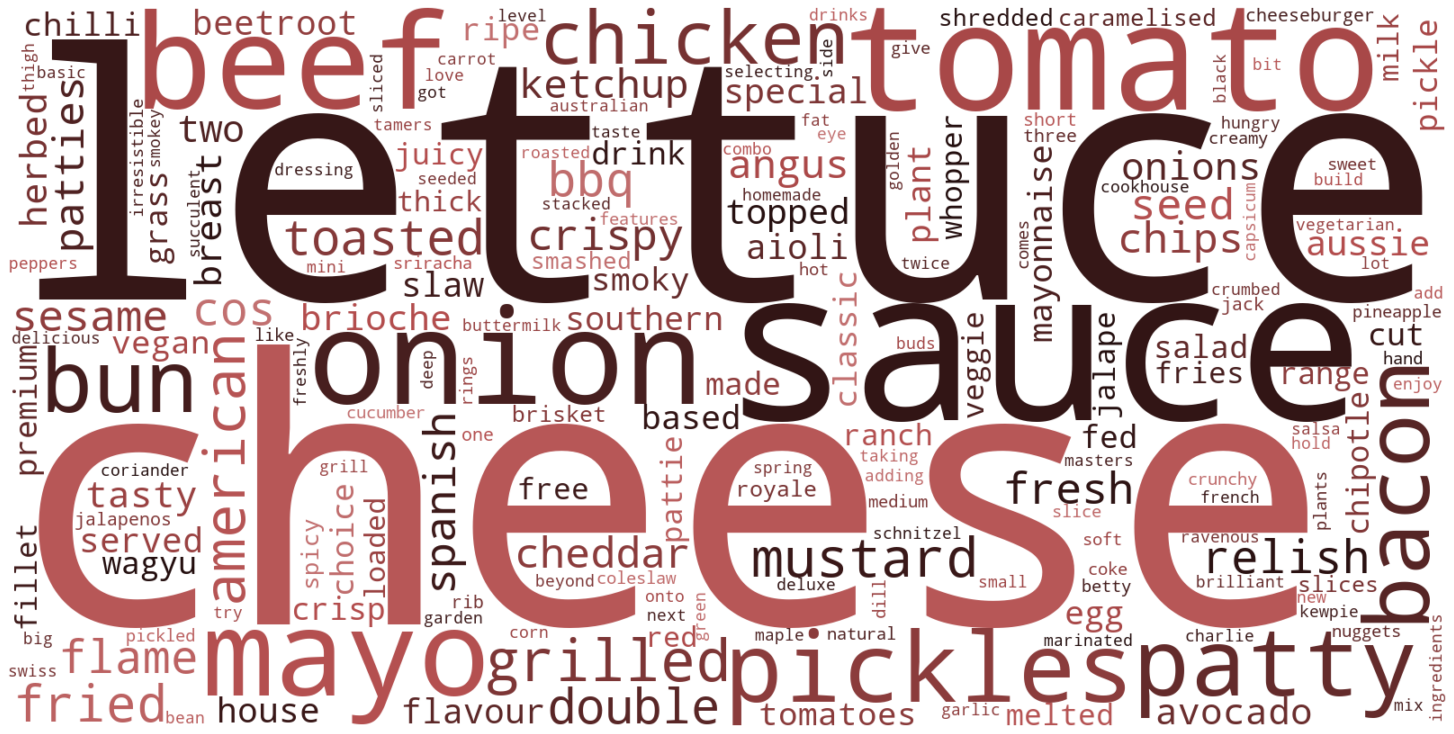

In [61]:
col = "description_kw"
mask = df_menus.is_burger

df_words = count_words(df_menus, col, mask)

mask = df_words.word.apply(lambda w: w not in ["burger", "burgers"])
plot_word_cloud(df_words[mask].head(200))

In [62]:
df_words.head(20)

,word,count
16,cheese,8976
12,lettuce,7865
35,sauce,7288
15,tomato,7171
5,onion,5497
11,beef,5391
0,mayo,4396
28,pickles,4351
9,patty,4117
7,bacon,3701


### Ingredients valued in beef burgers

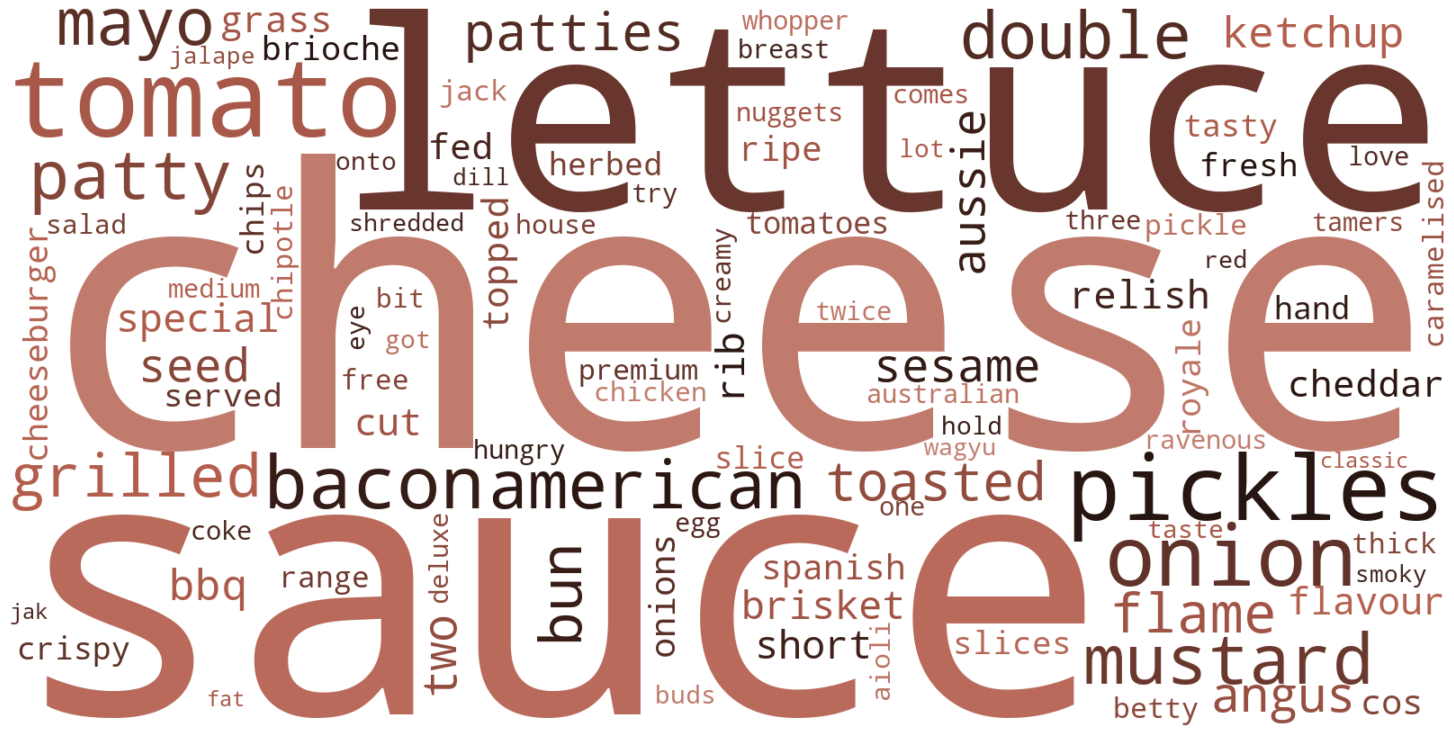

In [163]:
col = "description_kw"
mask = df_menus.is_burger & df_menus["kw"].apply(lambda kw: "beef" in kw)
df_words = count_words(df_menus, col, mask)

mask = df_words.word.apply(lambda w: w not in ["burger", "burgers", "beef"])
plot_word_cloud(df_words[mask].head(100), 10)


### Ingredients valued in chicken burgers

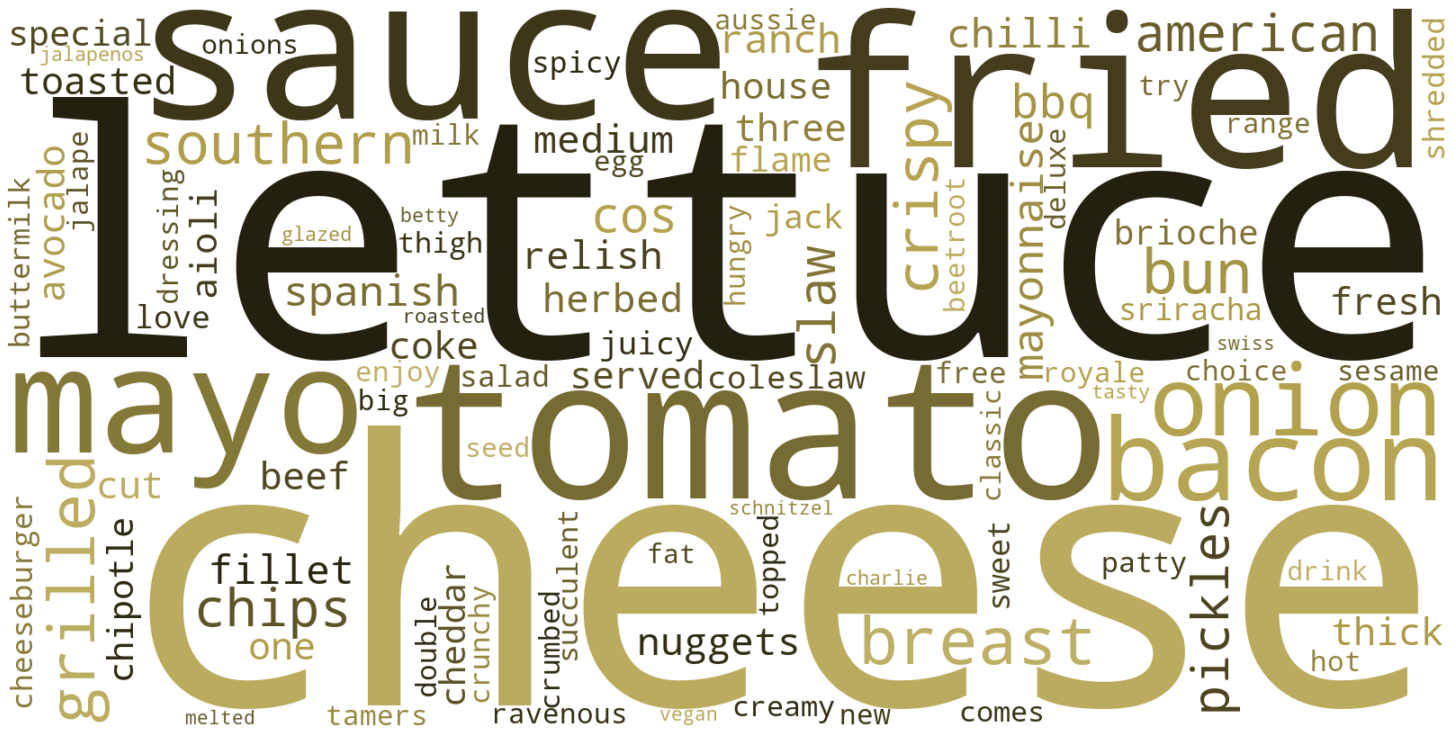

In [64]:
col = "description_kw"
mask = df_menus.is_burger & df_menus["kw"].apply(lambda kw: "chicken" in kw)
df_words = count_words(df_menus, col, mask)

mask = df_words.word.apply(lambda w: w not in ["burger", "burgers", "chicken"])
plot_word_cloud(df_words[mask].head(100), 50)

### Ingredients valued in vegan burgers

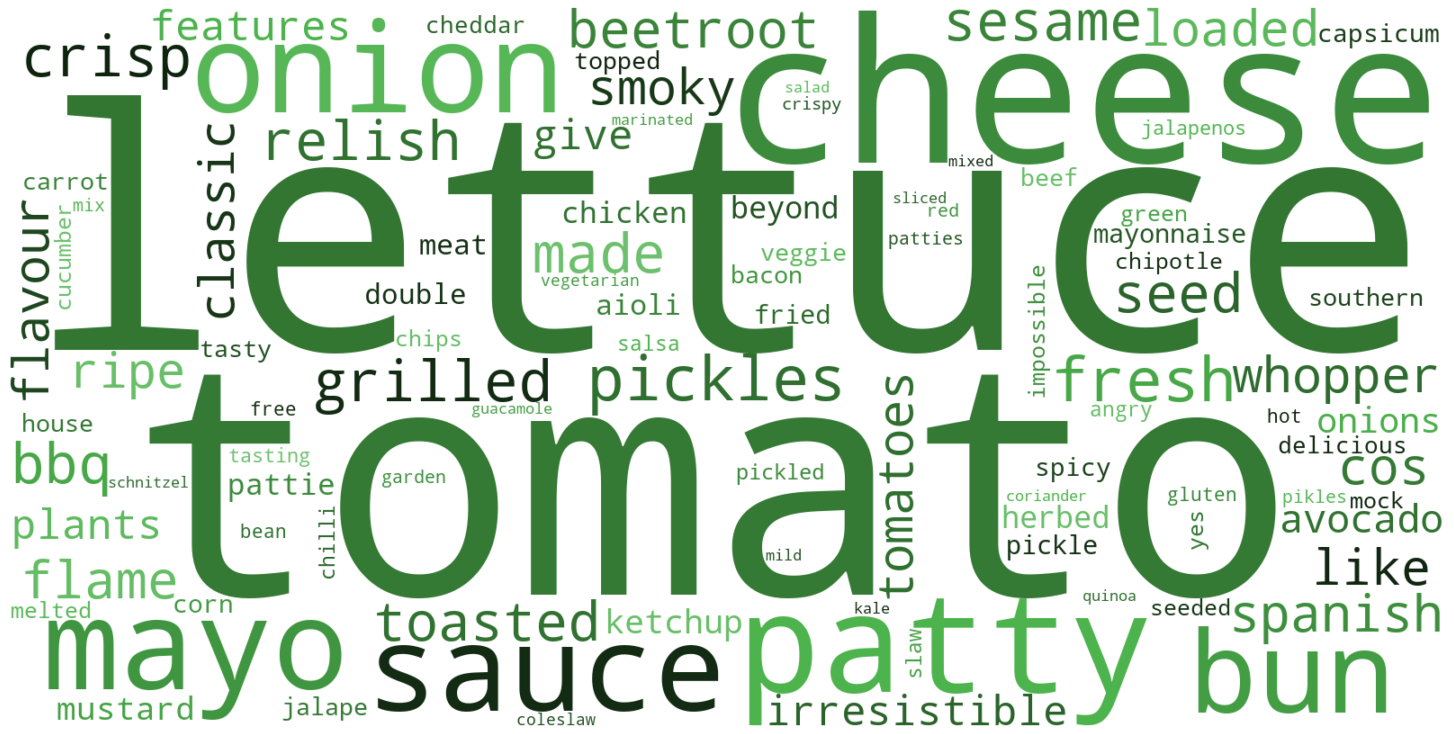

In [65]:
col = "description_kw"
mask = df_menus.is_burger & df_menus["kw"].apply(lambda kw: "vegan" in kw or "plant" in kw)

df_words = count_words(df_menus, col, mask)

mask = df_words.word.apply(lambda w: w not in ["burger", "burgers", "plant", "based", "vegan"])
plot_word_cloud(df_words[mask].head(100), 120)

### Price Analysis

In [66]:
burger_prices = df_menus[df_menus.is_burger].price.describe()
beef_prices = df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "beef" in kw)].price.describe()
chicken_prices = df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "chicken" in kw)].price.describe()
vegan_prices =  df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "vegan" in kw or "plant" in kw)].price.describe()

print("Burgers - Average %.2f AUD  Beetween %2.f AUD and %2.f AUD" % (burger_prices["50%"], burger_prices["25%"], burger_prices["75%"]))
print("Beef Burgers - Average %.2f AUD  Beetween %2.f AUD and %2.f AUD" % (beef_prices["50%"], beef_prices["25%"], beef_prices["75%"]))
print("Chicken Burgers - Average %.2f AUD  Beetween %2.f AUD and %2.f AUD" % (chicken_prices["50%"], chicken_prices["25%"], chicken_prices["75%"]))
print("Vegan Burgers - Average %.2f AUD  Beetween %2.f AUD and %2.f AUD" % (vegan_prices["50%"], vegan_prices["25%"], vegan_prices["75%"]))

Burgers - Average 17.90 AUD  Beetween 15 AUD and 20 AUD
Beef Burgers - Average 17.95 AUD  Beetween 15 AUD and 21 AUD
Chicken Burgers - Average 17.90 AUD  Beetween 16 AUD and 20 AUD
Vegan Burgers - Average 17.58 AUD  Beetween 16 AUD and 20 AUD


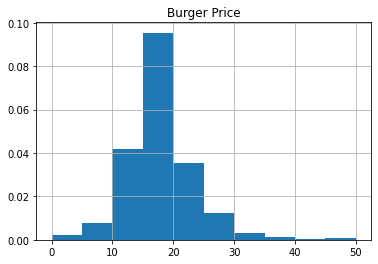

In [67]:
df_menus[df_menus.is_burger].price.hist(range=[0, 50], density=True);
plt.title('Burger Price');

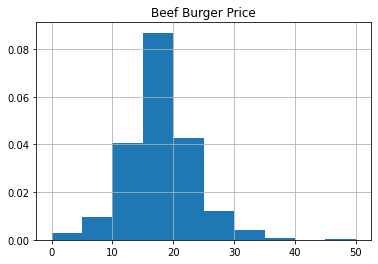

In [68]:
df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "beef" in kw)].price.hist(range=[0, 50], density=True);
plt.title('Beef Burger Price');

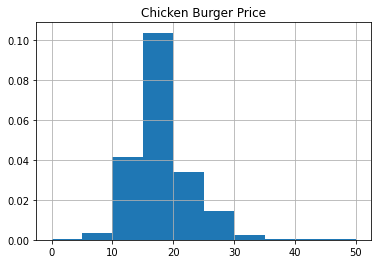

In [69]:
df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "chicken" in kw)].price.hist(range=[0, 50], density=True);
plt.title('Chicken Burger Price');

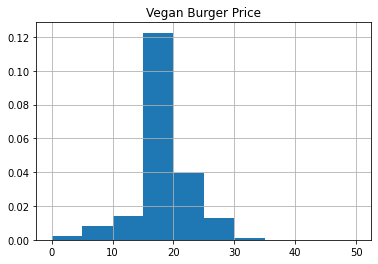

In [70]:
df_menus[df_menus.is_burger & df_menus["kw"].apply(lambda kw: "vegan" in kw)].price.hist(range=[0, 50], density=True);
plt.title('Vegan Burger Price');

In [196]:
df_stores["store_id"] = df_stores.store_id.astype(int)
df_stores[["store_id"]].to_csv("/Users/leo/Development/food/data/input/MEL_burger_stores.csv", index=False)

## Reviews

In [71]:
all_files = glob.glob(os.path.join(DATA_PATH , "MEL/reviews/*/*.json"), recursive=False)

store_id_list = df_stores.store_id.astype(int).tolist()

all_files = [filename for filename in all_files if int(filename.replace(".json", "").split("/")[-1]) in store_id_list]

In [72]:
# read menus
df_reviews = []
for file_path in all_files:
    store_id = int(file_path.replace(".json", "").split("/")[-1])

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        if "reviews" in data:
            df_reviews.extend(data["reviews"])
        
df_reviews = pd.DataFrame(df_reviews)
df_reviews = df_reviews.rename(columns={"storeId": "store_id"})
df_reviews["store_id"] = df_reviews.store_id.astype(int)

df_reviews = df_reviews.merge(df_stores[["store_id", "name", "business_id"]], on="store_id")

df_reviews["business_id"] = df_reviews.business_id.astype(int)

In [73]:
def count_review_words(df, col, mask):
    c_token = Counter()
    for _, row in df[mask].iterrows():
        tkns = row[col]
        c_token.update(tkns)
    df_words = pd.DataFrame([(w,c) for w,c in c_token.items()], columns=["word", "count"]).sort_values("count", ascending=False)
    return df_words

In [74]:
df_reviews["review_kw"] = df_reviews.reviewText.apply(lambda t: tokenizer.tokenize(t.lower()))
df_reviews["review_kw"] = df_reviews.review_kw.apply(lambda tkns: list(set([t for t in tkns if t not in stopwords])))

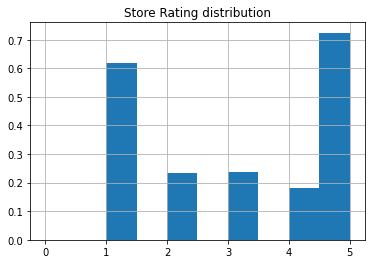

In [85]:
df_reviews.numStars.hist(density=True);
plt.title('Stores Rating distribution');

### Most common words in positive reviews

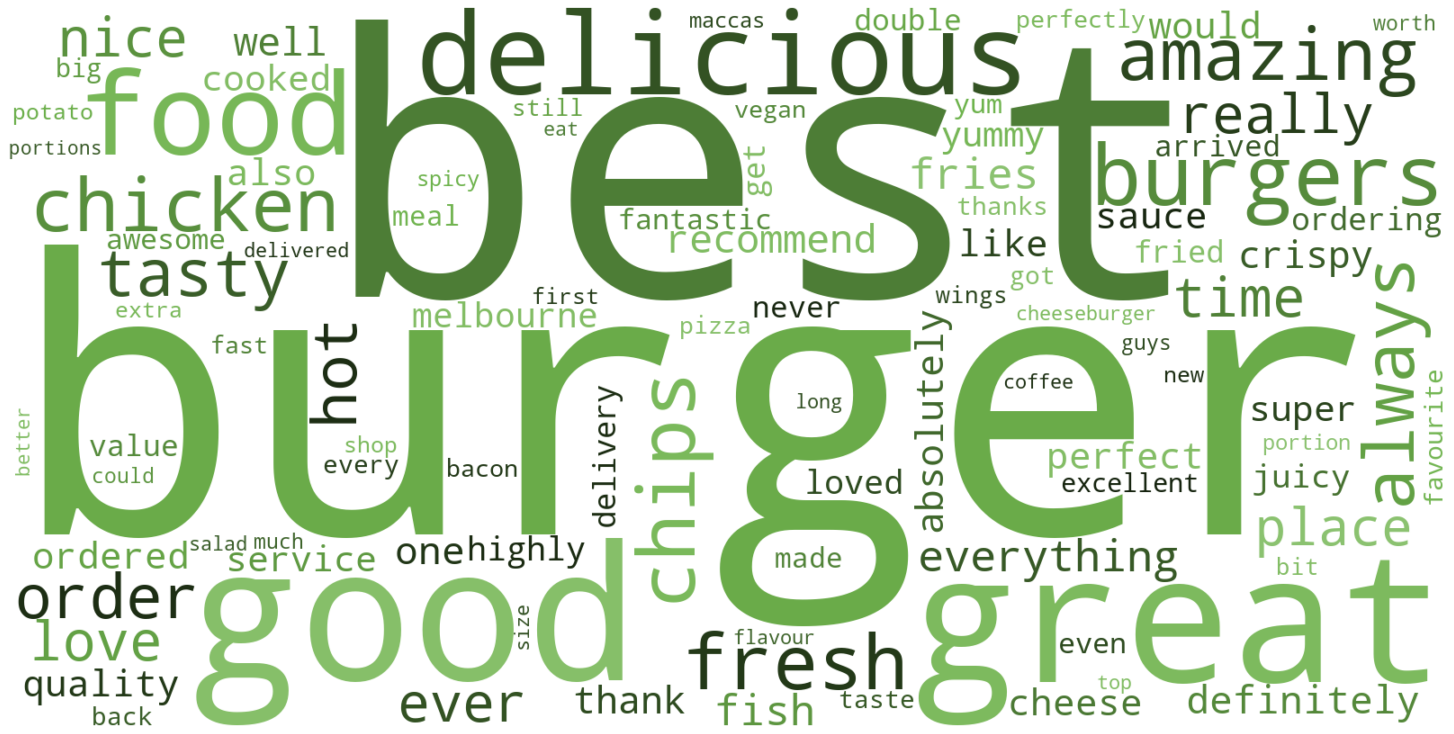

In [86]:
col = "review_kw"
mask = df_reviews.numStars == 5

df_pos_words = count_review_words(df_reviews, col, mask)

#mask = df_words.word.apply(lambda w: w not in ["burger", "burgers", "plant", "based", "vegan"])
plot_word_cloud(df_pos_words.head(100), 100)

### Most common words in negative reviews

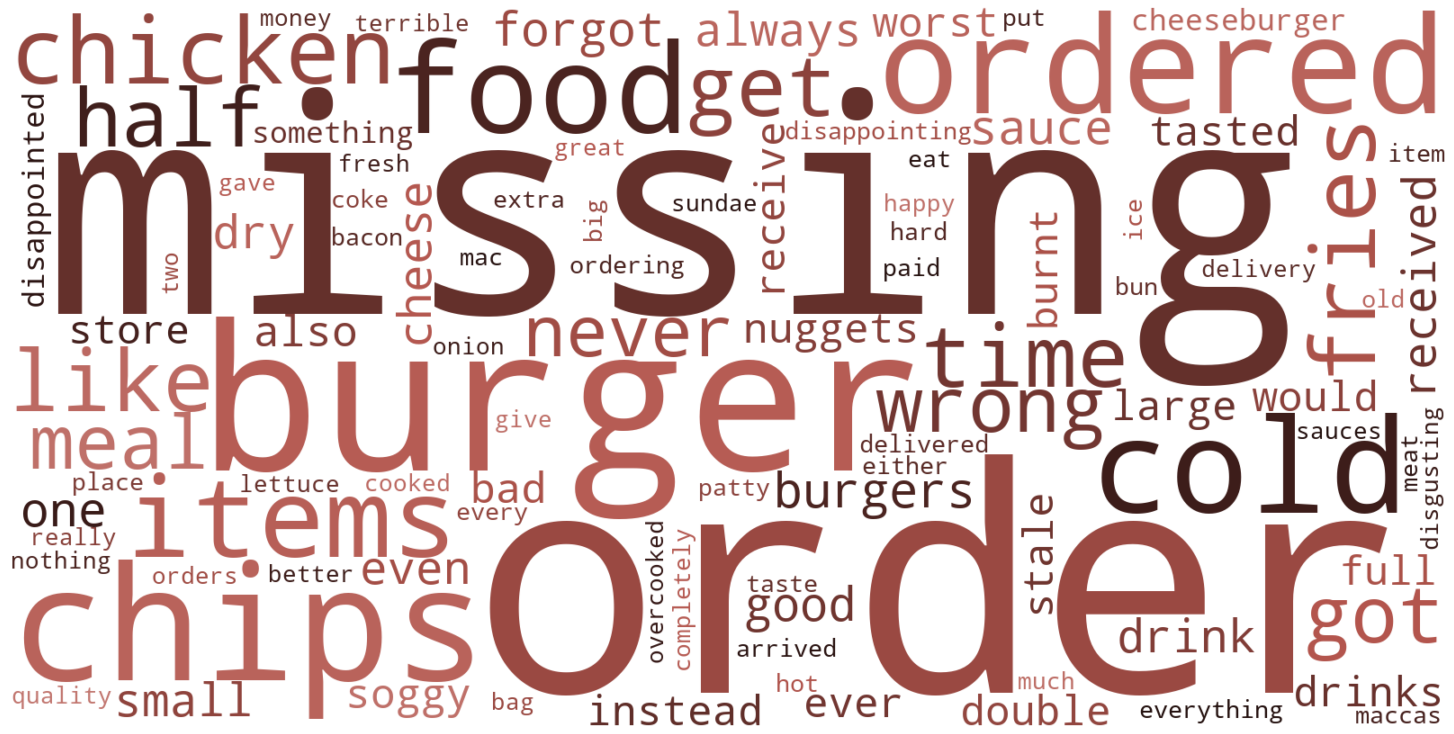

In [78]:
col = "review_kw"
mask = df_reviews.numStars < 3

df_neg_words = count_review_words(df_reviews, col, mask)

#mask = df_words.word.apply(lambda w: w not in ["burger", "burgers", "plant", "based", "vegan"])
plot_word_cloud(df_neg_words.head(100), 5)

### Customer similarities between brands

In [106]:
mask = (df_business.market_share_cumsum < 70.5)
business_ids = df_business[mask].business_id
business_names = df_business[mask].name
 

df_users = df_reviews[df_reviews.reviewerDisplayName != ""][["business_id", "reviewerDisplayName"]].copy()
distances = []

for business_A, name_A in zip(business_ids, business_names):
    set_a = set(df_users[df_users.business_id == business_A].reviewerDisplayName.unique())

    
    for business_B, name_B in zip(business_ids, business_names):
        if business_B != business_A:
            set_b = set(df_users[df_users.business_id == business_B].reviewerDisplayName.unique())
            jaccard = len(set(set_a & set_b)) / len(set(set_a | set_b))
            distances.append({"brand_A": name_A, "brand_B": name_B, "jaccard": jaccard})


distances = pd.DataFrame(distances)
distances = distances.pivot(index='brand_A', columns='brand_B', values='jaccard')
    #distances = distances.merge(df_business[["business_id", "name", "n_stores"]], on="business_id")

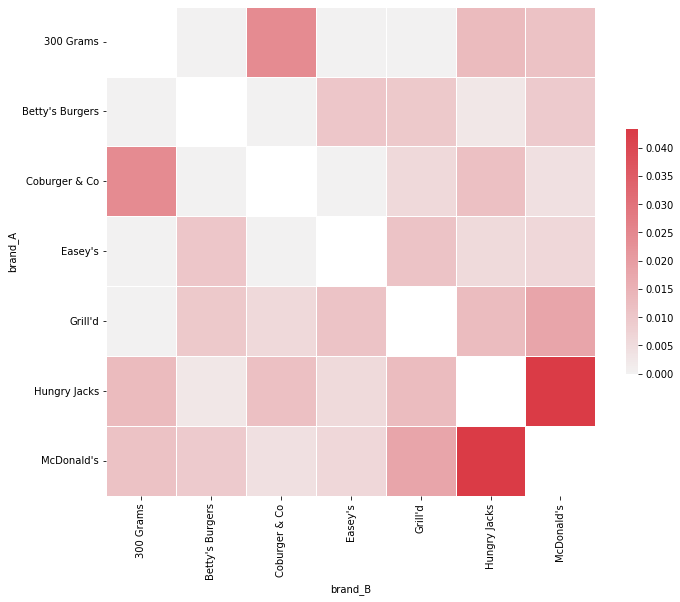

In [109]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(distances, cmap=cmap, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#sns.heatmap(distances)